<a href="https://colab.research.google.com/github/GostabMath/EssentialsCausalLearning/blob/main/Domain_Adap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Causal Learning and Counterfactuals

This documentation serves as a run-down for causal machine learning that covers some most classic methods and the most recent advancement. This is a document under active development and some materials will be a reflection or reference to Ruocheng Guo, a principal researcher at ByteDance,UK.

Because my central interest is counterfactual learning and bandit-based recommendation system, this document might not be a thorough reflection of anything you have seen in the causal world. Advice and commentes are welcome. Thank you for your interest in causal inference.

Topics will include:

-**Basic of Counterfactual Learning**:

-**Off-line Reinforcement Learning**:

This document will cover the these following topics: distribution shift, domain adaptation and distribution ratio estimation. I should stress that when those theory are a planned to be implemented to the real recommnedation systems, policies should be placed and updated in a more smart way. Therefore, that sparked two different foci.

1) *Estimating the distribution shift by developing more solid methods to estimate the distribution ratio*

2) *Find better ways to resolve distribution shift so that this issue will not affect our recommenders too much*

-**Causal Dicovery and Graphic Models**:

## Topic: Causal Discovery

In [ ]:
import pandas as pd
import numpy as np
from numpy.random import default_rng
from scipy import stats
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import graphviz as gr
import torch
from scipy.special import expit
from scipy.stats import sem
#from linearmodels.iv import IV2SLS

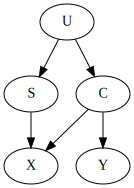

In [ ]:
g = gr.Digraph()
g.edge('U','C')
g.edge('U',"S")
g.edge("C","X")
g.edge('C',"Y")
g.edge("S","X")
g

## Topic: Off-line Reinforcement Learning and Off-policy Evaluation

### Domain Adaptation and Distribution Shift

Since domain-adaptation is an essential of off-line reinforcement learning, especially in the action-reward system, it is decent to include a summary here so that readers are capable of capturing central ideas that have been fully studied.

Covariates shift is a classic problem in estimating a target distribution with on-hand observed data. This theorem was supported by a mathematically rigorous field-Change of Measures in measure theory and probabiltiy.

Domain adaptation formulate a problem in reinforcement learning. This problem indicates we have concern in what we have observed that will be used to predict what we think represents the population. Therefore, the former one relects our sample setting but the latter focuses on the research of interest in population.

If we have observed a joint distribution $P(x_0,y_0) \in \mathcal{X \times Y}=p(y_0|x_0)p(x_0)$, we are trying to use the data under observed estimated distribution to predict the new distribution. Therefore, the distribution or covaraites have shifted. Given appropriate assumption that the conditional distribution $p(y_0|x)$ remains the same in both scenario, it is provably useful to use the ratio of two unconditional distributions $p(x_0)$ and $q(x)$. A correction weight $w=\frac{q(x_0)}{p(x_0)}$ is calculated and added to the scheduled estimator to correct this distribution shift. We will provide a short review of proof.

#### **A.** Reproducing a Distribution Shift Problem(simulation)

The first experimentation will be completely randomized uniformed policy from a observed policy $\mathcal{\pi_0}$.
$\mathbb{E}_{\mathcal{x}:\mathcal{P(X)}}[\sum r_{i}p(r_i|X)]$

- Basic setting-up of experiment

 Data generating distribution:

- $X\sim \text{Uniform}({0,1,2})$
- $Y|X=x\sim\mathcal{N}(x,1)$
- $R|X=x \sim \text{Bernoulli}(\text{expit}(4-4x))$


In [ ]:
def get_missing_seavan1_sample(n, rng, sigma):
    d = pd.DataFrame()
    d["x"] = rng.integers(0, 3, size=n)
    d["obs_prob"] = expit(4 - 4 * d["x"])
    d["obs"] = rng.random(n) <= d["obs_prob"]  # indicator that instance has observed Y
    d["y"] = rng.normal(loc=d["x"], scale=sigma)
    d["E[Y|X=x]"] = d["x"]
    return d

rng = default_rng(0)
sigma = 1.5
df = get_missing_seavan1_sample(1000, rng, sigma)
df.head()


,x,obs_prob,obs,y,E[Y|X=x]
0,2,0.017986,False,2.444634,2
1,1,0.500000,False,1.324833,1
2,1,0.500000,False,0.675943,1
3,0,0.982014,True,-0.902072,0
4,0,0.982014,True,-0.398701,0


In [ ]:
"""
    Each estimator takes 5 arguments:
        x: matrix of covariates
        y: vector of values
        pi: vector of propensities
        r: indicator of observation
        n: total number of datapoints
"""


def mean(x, y, pi, r, n):
    """Mean of the observed values"""
    return np.mean(y[r])

def ipw_mean(x, y, pi, r, n):
    """Inverse propensity weighting estimator"""
    return np.mean(np.mat(y,1/pi))

def sn_ipw_mean(x, y, pi, r, n):
    """Self-normalized inver propensity weighting estimator"""
    return (np.inner(y,1/pi))/np.sum(r)


def impute_linear(x, y, pi, r, n):
    """Estimator using imputed values for the missing observations.
       Imputation computed using linear regression trained on the observed observations."""
    reg = LinearRegression(fit_intercept=True, normalize=False).fit(
                            X=x[r], y=y[r])
    full_impute = reg.predict(x)
    missing_impute = full_impute.copy()
    missing_impute[r] = y[r] # don't impute the observed values
    return np.mean(missing_impute)

def impute_ipw_linear(x, y, pi, r, n):
    """Estimator using imputed values for the missing observations.
       Imputation computed using inverse propensity weighted linear regression."""
    raise NotImplementedError

def impute_iw_linear(x, y, pi, r, n):
    """Estimator using imputed values for the missing observations.
       Imputation computed using importance weighted linear regression."""
    raise NotImplementedError